## Introduzione

In questa esercitazione ci occupiamo di determinare il minimo di un funzionale. Considerando la formulazione variazionale del problema agli autovalori in meccanica quantistica, possiamo scrivere:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

Dove $E_0$ rappresenta un limite inferiore ai possibili valori di energia, ed è quindi considerata come energia associata allo stato fondamentale.

Durante l'esercizio consideriamo una particella in una dimensione soggetta al seguente potenziale:

$$
V(x) = x^4 - \frac{5}{2}x^2
$$

Per poter trattare numericamente il problema, utilizzando un ansatz possiamo restringerci a una particolare classe di funzioni ed esplorare lo spazio dei parametri ad essa associato. Per questo problema consideriamo l'ansatz:

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

Il quale dipende da due parametri $\mu$ e $\sigma$. In teoria lo spazio è dato da $\mathbb{R}^2$, noi ne esploreremo una piccola porzione intorno all'origine.

### Esercizio 08.1

In questa prima parte dell'esercizio scriviamo un codice che sfrutta l'algoritmo di Metropolis per campionare la distribuzione di probabilità data da $|\Psi_T^{\sigma,\mu}(x)|^2$, con parametri $\sigma$, $\mu$ fissati. Ho implementato il codice sulla scia di quanto fatto nelle esercitazioni precedenti, considerando una funzione di transizione gaussiana e regolandone la larghezza in modo da avere un'accettazione intorno al 50%. I punti campionati sono stati quindi utilizzati per calcolare il seguente integrale:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}=
$$
con 
$$
\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}=-\frac{1}{2\sigma^4}\bigg[m^2-2 m x \tanh{\frac{m x}{\sigma^2}-\sigma^2+x^2}\bigg]+V(x)
$$

Ho quindi proceduto con il calcolare numerose volte questo integrale per diversi valori di $\mu$ e $\sigma$. Nel dettaglio ho esplorato lo spazio $(\sigma,\mu)\in[0.1,2.1]$x$[-0.5,2.5]$ con una risoluzione di 800x800. Ogni integrale è stato calcolato con media a blocchi utilizzando $10^4$ valori in $100$ blocchi. In ogni caso il calcolo non vuole avere finalità strettamente quantitative, quanto aiutare nella visualizzazione del problema.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def ShowPlot(string1, colormapz):
    # Read data from file
    data = np.loadtxt('c++/output_Hmat'+string1+'.txt')

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(15, 10))
    heatmap = ax.imshow(data, cmap=colormapz)

    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Set labels and title
    ax.set_xlabel('$\sigma$',fontsize=15)
    ax.set_ylabel('$\mu$',fontsize=15)
    ax.set_title('Heatmap | Log(H+1)', fontsize=20)

    # Set the ticks and labels for the x-axis
    x_ticks = np.linspace(0, data.shape[1] - 1, 5)
    x_tick_labels = np.linspace(0.1, 2.1, 5)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    # Set the ticks and labels for the y-axis
    y_ticks = np.linspace(0, data.shape[0] - 1, 5)
    y_tick_labels = np.linspace(2.5, -0.5, 5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)

    plt.savefig("Energy_"+string1+colormapz+".pdf", format="pdf", bbox_inches="tight")

    # Show the plot
    plt.show()

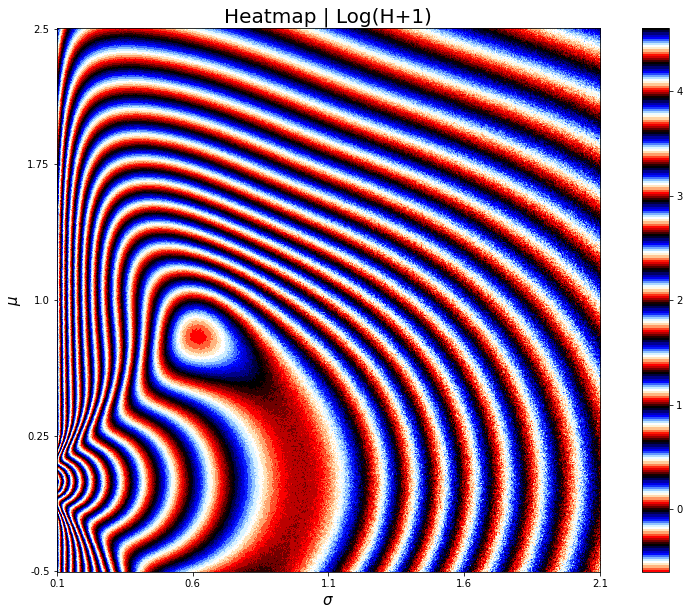

In [25]:
ShowPlot('_2.500000','flag')

In questa heatmap non è presente direttamente l'energia ma $\log(H+1)$. Il logaritmo smorza le divergenze man mano che ci si allontana dal minimo e aiuta la visualizzazione. L'aggiunta di una unità nell'argomento è giustificata dal fatto che il calcolo semiclassico ci dice che il minimo vale $\sim-0.44$, e così possiamo ottenere valori positivi dell'argomento.

La simulazione che ha prodotto questa immagine ha richiesto diverse ore ($\sim 5$ ore per valutare $6,4*10^5$ integrali con media a blocchi) e ha esplorato una parte relativamente piccola dello spazio dei parametri. In un grafico di questo tipo il minimo è immediatamente individuabile, tuttavia il procedimento richiede uno spreco notevole di tempo di computazione (a meno che l'obiettivo non sia quello di creare immagini psichedeliche...). E' esattamente per questo motivo che nella sezione seguente si considerano metodi alternativi per esplorare lo spazio dei parametri in modo molto più efficiente.

### Simulated Annealing

Il Simulated Annealing è una delle tecniche che possono essere usate per trovare la coppia di parametri che caratterizza il minimo dell'energia. L'algoritmo funziona in modo estremamente simile a quello di Metropolis. In questo caso abbiamo un problema di ottimizzazione che può essere mappato in un problema di fisica statistica (annealing) considerando la distribuzione di probabilità:

$$\rho(\sigma,\mu)=\frac{1}{Z}\exp(-\beta H(\sigma,\mu))$$

Dove $H(\sigma,\mu)$ rappresenta la funzione di costo, e $\beta$ l'inverso di una temperatura fittizia. Più $\beta$ aumenta, più la densità di probabilità diventa piccata nei suoi massimi e minimi. 

L'idea è quindi quella di implementare un algoritmo di Metropolis utilizzando una densità di probabilità come quella scritta prima. Inizialmente $\beta$ sarà tenuto su valori bassi in modo che la distribuzione non sia piccata e in modo che l'algoritmo possa esplorare zone vaste senza fermarsi in minimi locali. Man mano che la simulazione avanza $\beta$ viene progressivamente aumentato in modo da far esplorare più nel dettaglio la zona di minimo in cui plausibilmente si è arrivati.

Ho implementato l'annealing facendo aumentare $\beta$ con passi costanti pari a 2. In teoria ad ogni riduzione di $\beta$ bisognerebbe fare alcuni passi mantenendolo constante in modo che il sistema abbia il tempo di equlibrarsi. Da quello che ho potuto vedere lo step è comunque abbastanza piccolo da non rappresentare una grande variazione per il sistema, quindi ho implementato un aumento costante. Ho fatto in modo che anche i salti nelle variabili $(\sigma,\mu)$ dipendessero da $\beta$, e per fare questo ho considerando due fasi:

1. Ricerca su grande scala: $\Delta\sigma,\Delta\mu\sim\beta^{-\frac{1}{4}}$. I passi rimangono abbastanza ampi anche dopo aver aumentato di molto $\beta$ e l'algoritmo continua a esplorare zone vaste. 3000 passi.
2. Ricerca nel dettaglio: $\Delta\sigma,\Delta\mu\sim\beta^{-\frac{1}{2}}$. Una volta che ci si è avvicinati al minimo assoluto, si inizia a cercarlo con maggiore dettaglio e facendo passi sempre più piccoli. 3000 passi.

Il punto di partenza scelto è $\sigma=20.1$ e $\mu=15.5$

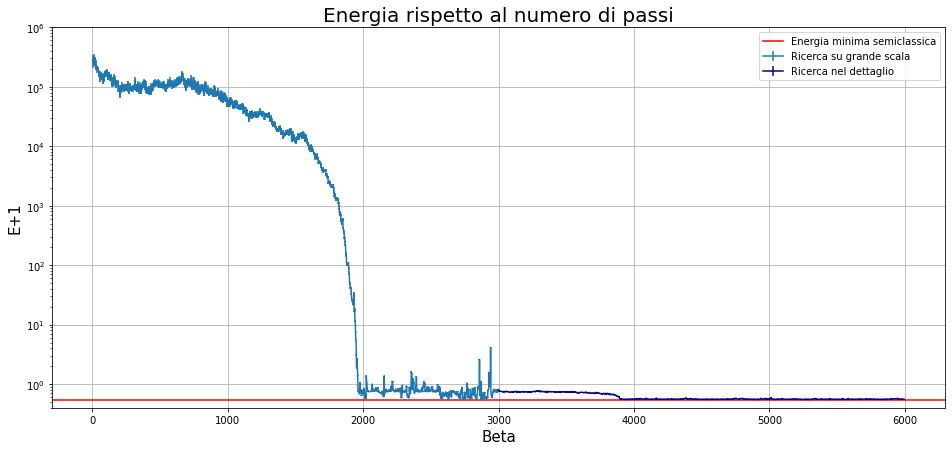

In [46]:
beta, E, err_E = np.loadtxt("c++/output_ESAeq.txt",usecols=(0,1,2), unpack=True)
beta2, E2, err_E2 = np.loadtxt("c++/output_ESA.txt",usecols=(0,1,2), unpack=True)

plt.figure(figsize=(16, 7))
plt.errorbar(beta,E+1,err_E, label="Ricerca su grande scala")
plt.errorbar(beta2,E2+1,err_E2, color="darkblue", label="Ricerca nel dettaglio")
plt.axhline(y=-0.46+1, color ="r", label = "Energia minima semiclassica")
plt.title("Energia rispetto al numero di passi", fontsize=20)
plt.xlabel('Beta',fontsize=15)
plt.ylabel('E+1',fontsize=15)
plt.yscale('log')
plt.ylim([0.4,1e6])
plt.legend()
plt.grid(True)
plt.show()

Dal grafico si vede che dopo una prima fase piuttosto stabile l'algoritmo si dirige repentinamente verso il minimo e inizia a oscillarci intorno con passi ancora grossolani. A quel punto entra il gioco la seconda parte della ricerca, dove i passi più piccoli permettono una ricerca raffinata che va a convergere verso il minimo. Di seguito si riportano un paio di zoomate nella seconda parte della ricerca dove è possibile anche apprezzare le incertezze (calcolate con media a blocchi).

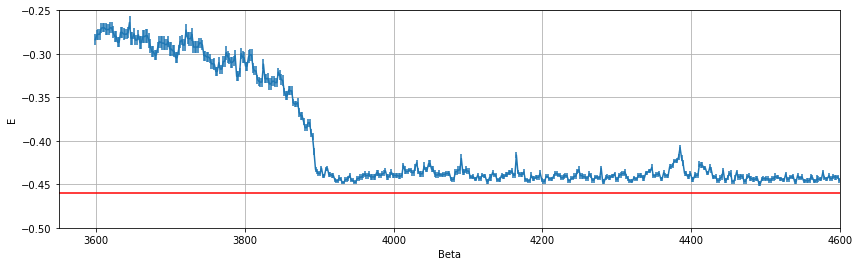

In [57]:
beta, E, err_E = np.loadtxt("c++/output_ESA.txt",skiprows=300,usecols=(0,1,2),unpack=True)

plt.figure(figsize=(14, 4))
plt.errorbar(beta,E,err_E)
plt.axhline(y=-0.46, color ="r", label = "Energia minima semiclassica")
plt.xlabel('Beta')
plt.ylabel('E')
#plt.yscale('log')
plt.ylim([-0.5,-0.25])
plt.xlim([3550,4600])
plt.grid(True)
plt.show()

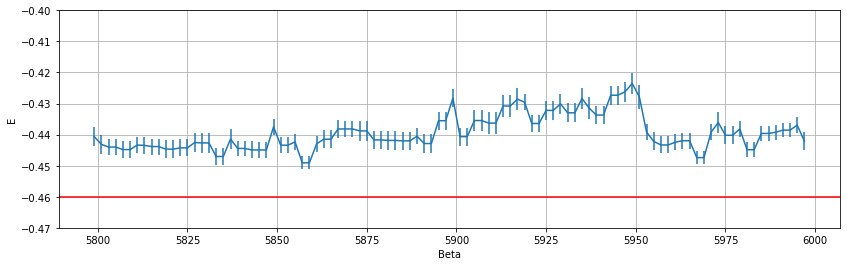

In [58]:
beta, E, err_E = np.loadtxt("c++/output_ESA.txt",skiprows=1400,usecols=(0,1,2),unpack=True)

plt.figure(figsize=(14, 4))
plt.errorbar(beta,E,err_E)
plt.axhline(y=-0.46, color ="r", label = "Energia minima semiclassica")
plt.xlabel('Beta')
plt.ylabel('E')
#plt.yscale('log')
plt.ylim([-0.47,-0.4])
plt.grid(True)
plt.show()

Notiamo due cose: La prima è che pur essendoci avvicinati a quello che sembra essere il minimo dell'energia, non riusciamo a raggiungere il valore del calcolo approssimaot analitico. Questo è dovuto al fatto che abbiamo considerato un particolare ansatz che non necessariamente contiene la funzione d'onda che veramente minimizza l'energia. Questo in realtà non è un problema nel momento in cui possiamo accontentarci di un risultato approssimato.
La seconda questione riguarda le oscillazioni. Notiamo che le oscillazioni dovute alla ricerca del minimo sono maggiori rispetto a quello che si ottiene come incertezza nel calcolo dell'integrale a $\sigma$ e $\mu$ fissati. Questo ci dice che una stima dell'incertezza di H  potrebbe essere data dall'ampiezza delle oscillazioni in questo range rispetto che alla stima con data blocking a $\sigma$ e $\mu$ fissati.

Di seguito un paio di visualizzazioni dell'ultima parte del percorso nello spazio dei parametri:

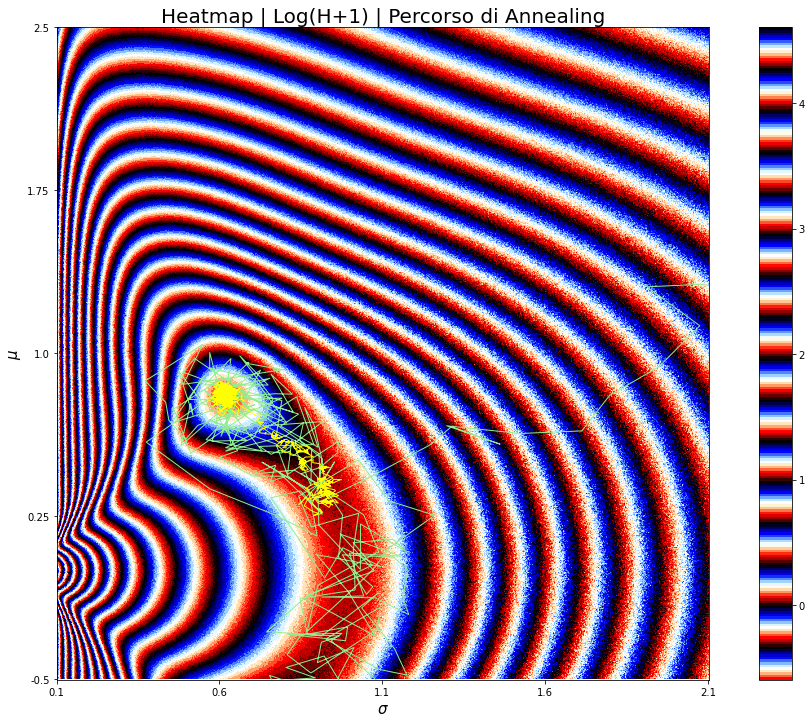

In [51]:
def RescaleS(sigma):
    return (sigma-0.1)*800/2.
def RescaleM(mi):
    return (2.5-mi)*800/3.

# Generate random heatmap data
heatmap_data = np.loadtxt('c++/output_Hmat_2.500000.txt')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(18, 12))

# Set the ticks and labels for the x-axis
x_ticks = np.linspace(0, heatmap_data.shape[1] - 1, 5)
x_tick_labels = np.linspace(0.1, 2.1, 5)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

# Set the ticks and labels for the y-axis
y_ticks = np.linspace(0, heatmap_data.shape[0] - 1, 5)
y_tick_labels = np.linspace(2.5, -0.5, 5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)

# Plot the heatmap
heatmap = ax.imshow(heatmap_data, cmap='flag')

# Define the path coordinates
y,x = np.loadtxt("c++/output_ESAeq.txt",skiprows=950,usecols=(3,4),unpack=True)
y1,x1 = np.loadtxt("c++/output_ESA.txt",usecols=(3,4),unpack=True)

y = RescaleM(y)
x = RescaleS(x)
y1 = RescaleM(y1)
x1 = RescaleS(x1)
# Plot the path on top of the heatmap
ax.plot(x, y, color='lightgreen', linewidth=1.0)
ax.plot(x1, y1, color='yellow', linewidth=1.0)
ax.set_xlabel('$\sigma$',fontsize=15)
ax.set_ylabel('$\mu$',fontsize=15)
ax.set_title('Heatmap | Log(H+1) | Percorso di Annealing', fontsize=20)

# Add a colorbar for the heatmap
plt.colorbar(heatmap)
plt.xlim((RescaleS(0.1),RescaleS(2.1)))
plt.ylim((RescaleM(-0.5),RescaleM(2.5)))

plt.savefig("Energy_Path", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

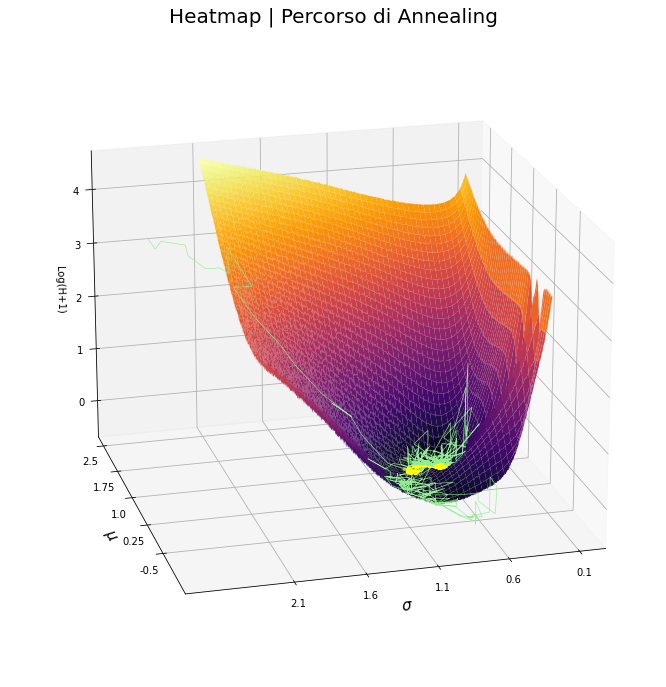

In [52]:
# Load data from the file
data = np.loadtxt('c++/output_Hmat_2.500000.txt')

# Generate X, Y coordinates based on the shape of the matrix
X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Plotting the 3D function
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, cmap="inferno")
ax.view_init(elev=20, azim=75)  # Adjust the elev and azim angles as desired

# Set the ticks and labels for the x-axis
x_ticks = np.linspace(0, data.shape[1] - 1, 5)
x_tick_labels = np.linspace(0.1, 2.1, 5)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

# Set the ticks and labels for the y-axis
y_ticks = np.linspace(0, data.shape[0] - 1, 5)
y_tick_labels = np.linspace(2.5, -0.5, 5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)

# Add labels and title
ax.set_xlabel('$\sigma$',fontsize=15)
ax.set_ylabel('$\mu$',fontsize=15)
ax.set_zlabel('Log(H+1)')
ax.set_title('Heatmap | Percorso di Annealing', fontsize=20)


# Load path data
E, y, x = np.loadtxt("c++/output_ESAeq.txt", skiprows=950, usecols=(1, 3, 4), unpack=True)
E1, y1, x1 = np.loadtxt("c++/output_ESA.txt", usecols=(1, 3, 4), unpack=True)

# Rescale the y and x coordinates as needed
y = RescaleM(y)
x = RescaleS(x)
y1 = RescaleM(y1)
x1 = RescaleS(x1)

# Plot the path on top of the 3D function with higher Z-order
line = ax.plot(x, y, np.log(E + 1), color='lightgreen', linewidth=0.6)
line1 = ax.plot(x1, y1, np.log(E1 + 1), color='yellow', linewidth=0.6)
line[0].set_zorder(10)
line1[0].set_zorder(20)

plt.savefig("Energy_Path3D", format="pdf", bbox_inches="tight")

plt.show()

Scegliamo quindi i valori di $\sigma$ e $\mu$ negli ultimi 200 passi hanno minimizzato l'energia e per tali valori stampiamo un grafico della media a blocchi:

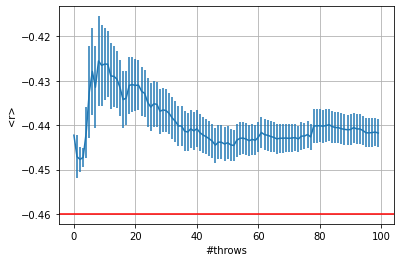

In [53]:
blk,sum_prog, err_prog = np.loadtxt("c++/output_EnergyMin.txt",usecols=(0,1,2), unpack=True)
plt.axhline(y=-0.46, color ="r", label = "Target temperature: ")

plt.errorbar(blk,sum_prog,yerr=err_prog)
plt.xlabel('#throws')
plt.ylabel('<r>')
plt.grid(True)
plt.show()

Campioniamo infine la funzione d'onda associata ai parametri che minimizzano l'energia e la confrontiamo con la funzione d'onda derivante dal calcolo approssimato analitico. 

(-3.0, 3.0)

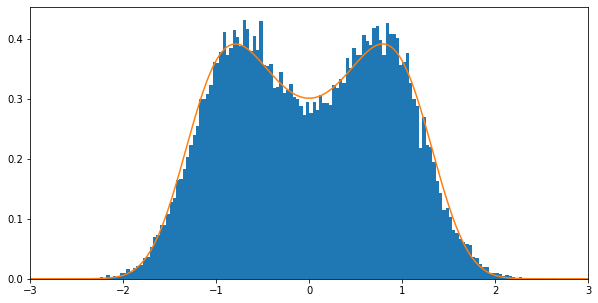

In [60]:
Pos=np.loadtxt("c++/output_Pos.txt")

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

# Step sizes
plt.figure(figsize=(10, 5))
matplotlib.pyplot.hist(Pos,bins=150,density=True)
x = np.linspace(-a/2, a/2, N)
plt.plot(x,(psi[0])**2)
plt.xlim((-3,3))

Notiamo che le due distribuzioni sono paragonabili, fatto che convalida la bontà dell'ansatz e che giustifica la vicinanza dell'energia trovata con il minimo dato dall'approssimazione analitica.